# Grundlagen der KI - Gruppenprojekte


Für die Projekte stellen wir eine MongoDB Datenbank, die wir aktiv in der Forschung nutzen, zur Verfügung. Die Datenbank beinhaltet Informationen über Versionskontrollsysteme, Issuetracker, und Mailinglisten von Open Source Projekten. [Die Dokumentation der Datenbank finden Sie Online](https://smartshark2.informatik.uni-goettingen.de/documentation/).

## Die Aufgabe

Ihre Aufgabe ist es, einen automatisierten Ansatz zu entwickeln, welcher vorhersagt, ob ein Issue innerhalb von 6 Monaten behoben wird oder nicht. Darüber hinaus, sollte das Modell (oder auch ein zweites Modell) in der Lage sein, die erwartete Zeit für die Behebung und damit Schließung des Issues vorherzusagen.
Sie können dazu beliebige Informationen aus der Datenbank nutzen, wie z.B. Commits, andere Issues, Mails und Änderungen in den Dateien.
Sie müssen diese Problemstellung als Analyseproblem fassen um dann Modelle zur Lösung aufstellen zu können. Hierzu müssen Sie geeignete Analysemethoden auswählen und anschließend die Qualität der Ergebnisse evaluieren. 

## Präsentationen

**Alle Gruppen müssen ihre Ergebnisse in der letzten Vorlesung am 09.02. um 16:15 Uhr vorstellen.** Hierzu muss jede Gruppe eine kurze Präsentation halten. In dieser Präsentation sollten Sie kurz beschreiben wie Sie vorgegangen sind, wie Sie Features erstellt haben, welche Modelle Sie benutzt haben und was ihre wichtigsten Ergebnisse sind. Die Zeit für die Präsentation beträgt 9 (1) Minuten.

Im Anschluss an die Präsentation stimmen die Anwesenden über das beste Projekt ab. Jede Gruppe stimmt für das beste Projekt (3 Punkte), das zweitbeste (2 Punkte) und das drittbeste (1 Punkt). Das Projekt mit den meisten Punkten gewinnt einen Preis.

Die Präsentation wird in Präsenz stattfinden, wenn die aktuellen Regeln es zulassen (Prof. Herbold wird dabei per Video zugeschaltet sein; Raum wird noch bekannt gegeben). Da wir nur begrenzt Zeit haben, müssen alle Präsentationen vorab geschickt werden. Wir kombinieren diese dann in einer PDF um einen einfachen Wechsel zwischen den Präsentation der Gruppen zu erreichen. Die Mitglieder der Gruppe werden dann in der Reihenfolge des Gruppennames gebeten ihre Ergebnisse vorzustellen, d.h. wir beginnen mit Gruppe 1 und enden mit Gruppe 6.


## Abgabe der Präsentationen

Damit die Präsentation reibungslos ablaufen, müssen Sie ihre Präsentation im Vorfeld einsenden. **Schicken Sie Ihre Präsentationen bitte bis spätestens zum 08.02.23, 16 Uhr an Clemens Dierks via Email (clemens.dierks@tu-clausthal.de)**. Die Präsentation muss als PDF vorliegen.


## Mindestkriterien

Die folgenden Kriterien muss ein Projekt mindestens erfüllen, damit die Gruppenmitglieder an der Prüfung teilnehmen können.
- Es muss ein Modell für die automatisierte Vorhersage, ob ein Issue innerhalb von 6 Monaten gelöst wird, vorhanden sein.
- Es muss ein Modell für die automatisierte Vorhersage der estimated-time-to-fix von Issues vorhanden sein.
- Die Qualität des Modells muss bewertet werden.
- Sie müssen eine Empfehlung geben, ob und ggf. unter welchen Umständen, das Modell eingesetzt werden kann basierend auf der Evaluation der Qualität des Modells.
- Aufgrund Ihrer Empfehlung können Sie noch Verbesserungsmöglichkeiten vorstellen.
- Die Ergebnisse müssen in der Vorlesung am 09.02.23 vorgestellt werden.

## Datenbankzugriff

Unterhalb finden Sie ein Beispiel, wie Sie auf die Datenbank zugreifen. Die Datenbank befindet sich hinter einer Firewall und kann nur aus dem Netz der TU Clausthal erreicht werden. Wenn Sie Probleme haben die Datenbank zu erreichen, können Sie von jedem beliebigen Netzwerk aus in das Netz der TU Clausthal gelangen, in dem Sie sich mit dem [VPN](https://doku.tu-clausthal.de/doku.php?id=netzwerk_und_internet:vpn:start) verbinden.

**WARNUNG:
Wir benutzen die Datenbank aktiv in der Forschung. Es kann daher sein, das teilweise eine sehr hohe Last auf der Datenbank ist. Die Datenbank ist sehr groß und beinhaltet derzeit 4.8 Terabyte an Daten. Sie sollten daher nicht einfach starten Anfragen zu schreiben, sondern sich genau überlegen auf welche Informationen Sie zugreifen wollen. Wenn Sie zum Beispiel eine Anfrage stellen, in der Sie die komplette ```commit``` Collection herunterladen möchten, müssen Sie hierfür 158 Gigabyte an Daten runterladen. **

Sie können die Bibliothek [pycoSHARK](https://github.com/smartshark/pycoshark) zum Zugriff auf die Datenbank nutzen. Der pycoSHARK stellt einen ORM-Layer basierend auf der Bibliothek ```mongoengine``` zur Verfügung. Hierdurch können Sie die Datenbanktabellen wie Objekte behandeln. Alternativ können Sie die native MongoDB API der ```pymongo``` Bibliothek benutzen. 

Der Quelltext unten beinhaltet Ihre Zugangsdaten in zeigt wie man mit dem pycoSHARK auf die Datenbank zugreift.

Interesting features: No. of commits of the issue creator,age of the branch 

In [ ]:
# Installation des pycoSHARKs
import sys
# !{sys.executable} -m pip install pycoshark

In [1]:

from mongoengine import connect, disconnect
from sklearn import metrics
import seaborn as sns
from pycoshark.mongomodels import File, FileAction, Commit, Project, VCSSystem, IssueSystem,Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message
from pycoshark.utils import create_mongodb_uri_string
import pandas as pd
import pandas_profiling as pp #best to be installed with anaconda since pip sometimes makes problems with pandas_profiling
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from imblearn.under_sampling import RandomUnderSampler
# Database credentials
user = 'grundlagenki2021'
password = '38BTGx71d'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

# Fetch project id and issue tracking system system id for the 'commons-math' project
# The only() decides the data that is actually retrieved from the MongoDB. 
# get() only works, when you query results in exactly one document, otherwise you have to use a loop to access the data
# an example with a loop is at the bottom of this example
#project = Project.objects(name='commons-math').only('id').get()
#issue_system = IssueSystem.objects(project_id=project.id).only('id','url').get()
projectlist=[]
for items in Project.objects:
    #print (items.name)
    
    projectlist.append(items.name)
print(projectlist)


['commons-math', 'oisafe', 'ant-ivy', 'junit', 'kafka', 'zeppelin', 'mahout', 'struts', 'opennlp', 'pig', 'calcite', 'cayenne', 'falcon', 'kylin', 'nutch', 'parquet-mr', 'tika', 'wss4j', 'archiva', 'deltaspike', 'jspwiki', 'xerces2-j', 'tez', 'systemml', 'storm', 'lens', 'accumulo', 'commons-lang', 'james', 'pdfbox', 'flume', 'nifi', 'knox', 'derby', 'commons-collections', 'commons-beanutils', 'commons-codec', 'commons-compress', 'commons-configuration', 'commons-digester', 'commons-imaging', 'commons-io', 'commons-jcs', 'commons-jexl', 'commons-rdf', 'commons-scxml', 'commons-validator', 'commons-vfs', 'giraph', 'manifoldcf', 'ranger', 'eagle', 'commons-bcel', 'commons-dbcp', 'zookeeper', 'phoenix', 'gora', 'santuario-java', 'helix', 'jena', 'httpcomponents-client', 'commons-net', 'httpcomponents-core', 'streams', 'samza', 'roller', 'mina-sshd', 'bigtop', 'jackrabbit', 'tomcat', 'rhino', 'oozie', 'avro', 'activemq', 'fop', 'maven', 'airavata', 'openjpa', 'AutoUpdater.NET', 'directory-

Copied from https://github.com/smartshark/usage-examples/blob/main/Example-Notebook.ipynb:

In [2]:
def getreport(projectnames):
    projectdf = []
    for items in (projectnames):

        # We first need the the project from the database
        project = Project.objects(name=items).get()
        issue_tracker = IssueSystem.objects(project_id=project.id).get()
        dfin = pd.read_json(Issue.objects(
            issue_system_id=issue_tracker.id).to_json())
        # obtain the correct external_id for each repository to sort out invalid issues or logs
        extid = issue_tracker.url.rsplit('=', 1)[1]
        dfin = dfin[dfin.external_id.str.startswith(extid)]  # print(projectdf)
        print('read'+str(items))
        projectdf.append(dfin)
        print(len(projectdf))
    # print(projectdf[0])
    df1 = pd.concat(projectdf)
    #print(df1.shape)
    df = df1

    df['created_at'] = pd.json_normalize(df['created_at'])
    df['updated_at'] = pd.json_normalize(df['updated_at'])
    df['timetofix'] = (df.updated_at-df.created_at) / \
        (100*60*60*24*30.41)  # 30.17 im Schaltjahr
    df = df[[ 'issue_type', 'priority', 'status', 'timetofix']]
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=[
                         'priority', 'issue_type'])  # onehotencode# Entfernen von Außreisern
    #timetofix_25 = df['timetofix'].quantile(0.25)
    #timetofix_75 =df['timetofix'].quantile(0.75)

    #IQR_timetofix = (timetofix_75 - timetofix_25)
    #df = df[~((df['timetofix'] < (timetofix_25 - 1.5 * IQR_timetofix)) |(df['timetofix'] > (timetofix_75 + 1.5 * IQR_timetofix))).any(axis=0)]
    
    #df[df.timetofix > df.timetofix.quantile(.05)]# df = df.query(
    #     ' timetofix >= (@timetofix_25 - @IQR_timetofix) & timetofix <= (@timetofix_75 + @IQR_timetofix) ')
    dfc = df[df.timetofix > 0].copy()
    df['status'] = np.where(((df['status'] == 'Closed')| (df['status'] == 'Resolved')),  1, 0)
    df=df[df.status==1]
    df=df[(df.timetofix < df.timetofix.quantile(.70))&(df.timetofix > df.timetofix.quantile(.30))]
    # df['status'] = df['status'].replace('Closed', 1)
    # df['status'] = df['status'].replace('In Progress', 0)
    # df['status'] = df['status'].replace('Open', 0)
    # df['status'] = df['status'].replace('Resolved', 1)
    # df['status'] = df['status'].replace('Reopened', 0)
    # df['status'] = df['status'].replace('Patch Available', 0)
    dfc['status'] = np.where((((dfc['status'] == 'Closed') | (dfc['status'] == 'Resolved')) & (
        dfc['timetofix'] < 6)),  1, 0)  # give resolved and closed issues 1 that were fixed within 6 months

    #df=df[['external_id', 'creator_id', 'issue_type', 'priority', 'status' , 'timetofix']]
    # continue with selected columns
    
    dfc = dfc.dropna()
    
    print(dfc.shape)
    print(df.shape)
    return(dfc, df)


In [12]:
projectlist=['calcite']
#projectlist=['calcite','kylin','parquet-mr','cayenne','falcon','uima-ducc','archiva','xerces2-j','systemml','pig']
#projectlist=['jspwiki', 'xerces2-j', 'tez', 'systemml', 'storm', 'lens', 'commons-lang', 'pdfbox', 'flume', 'nifi', 'knox', 'derby', 'commons-collections', 'commons-beanutils', 'commons-codec', 'commons-compress', 'commons-configuration', 'commons-digester', 'commons-imaging', 'commons-io', 'commons-jcs', 'commons-jexl', 'commons-rdf', 'commons-scxml', 'commons-validator', 'commons-vfs', 'giraph', 'manifoldcf', 'ranger', 'eagle', 'commons-bcel', 'commons-dbcp', 'zookeeper', 'phoenix', 'gora', 'santuario-java', 'helix', 'jena']

dfclf,dfrgr=getreport(projectlist)



readcalcite
1
(2075, 14)
(654, 14)


In [ ]:
pp.ProfileReport(dfrgr, title="Pandas Profiling Report")

In [14]:


yclf = dfclf.status
Xclf = dfclf.drop(columns=['timetofix', 'status'])
Xclf_train, Xclf_test, yclf_train, yclf_test = train_test_split(Xclf, yclf, random_state=104,
                                                    test_size=0.25,
                                                    shuffle=True)  # 70% training and 30% test
# print('X_train : ')
# print(Xclf_train.head())
# print('')
# print('X_test : ')
# print(Xclf_test.head())
# print('')
# print('y_train : ')
# print(yclf_train.head())
# print('')
# print('y_test : ')
# print(yclf_test.head())


rus = RandomUnderSampler(random_state=0)

Xclf_train, yclf_train = rus.fit_resample(Xclf_train, yclf_train)

# print (yclf_train.value_counts())
# print (yclf_train.value_counts())

In [ ]:
# from scipy.stats import probplot
#  #QQ Plot
#  probplot(yerr, dist='norm', plot=plt)# Entfernen von Außreisern

# dfrgr.describe()

#  plt.figure()
# # # Errors
#  ax_x= performance['True Value']
#  ax_y= performance['Prediction']
#  yerr= performance['Error']

#  plt.scatter(range(len(yerr)), yerr, alpha=.5)
#  plt.title('Homogeneous Errors - KNN', size=15)# plt.hlines(y=0, xmin=0, xmax=6000, linestyle='--', color='white', alpha=.5)
# # #pa
# # # Paul Luter
# # 18:31

 

In [15]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LogisticRegression",
    

]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0),max_iter_predict=100000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    LogisticRegression(max_iter=10000),
   
]


Nearest Neighbors
Accuracy: 0.7649325626204239
Precision: 0.2
Recall: 0.017241379310344827
F1 Score: 0.031746031746031744
Average Precision: 0.22310145505282042
Linear SVM
Accuracy: 0.7167630057803468
Precision: 0.23728813559322035
Recall: 0.1206896551724138
F1 Score: 0.16000000000000003
Average Precision: 0.2251700151687652
RBF SVM
Accuracy: 0.3371868978805395
Precision: 0.21782178217821782
Recall: 0.7586206896551724
F1 Score: 0.3384615384615385
Average Precision: 0.2191940142788447
Gaussian Process
Accuracy: 0.7244701348747592
Precision: 0.2545454545454545
Recall: 0.1206896551724138
F1 Score: 0.16374269005847952
Average Precision: 0.2272527950423107
Decision Tree
Accuracy: 0.6936416184971098
Precision: 0.2345679012345679
Recall: 0.16379310344827586
F1 Score: 0.19289340101522842
Average Precision: 0.2253184850520576
Random Forest
Accuracy: 0.7129094412331407
Precision: 0.2608695652173913
Recall: 0.15517241379310345
F1 Score: 0.19459459459459458
Average Precision: 0.22930442293304218
N

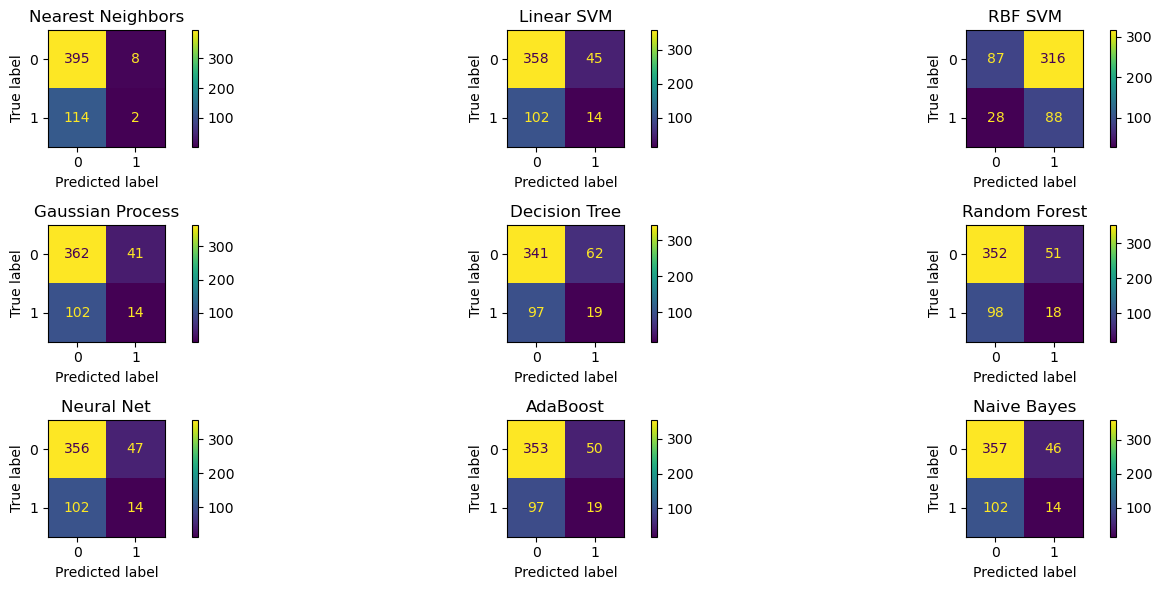

In [16]:

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(3,3, figsize=(15, 6), facecolor='w', edgecolor='k')

i=0
axes = axes.ravel()
for name, clf in zip(names, classifiers):

    clf.fit(Xclf_train, yclf_train)
    prediction = clf.predict(Xclf_test)
    print(name)
    print("Accuracy: "+str(metrics.accuracy_score(yclf_test, prediction)))
    print("Precision: "+str(metrics.precision_score(yclf_test, prediction)))
    print("Recall: "+str(metrics.recall_score(yclf_test, prediction)))
    print("F1 Score:", metrics.f1_score(yclf_test, prediction))
    print("Average Precision:", metrics.average_precision_score(
        yclf_test, prediction))
    #ConfusionMatrixDisplay.from_estimator(clf, Xclf_test, yclf_test)
    #cm = metrics.confusion_matrix(yclf_test, prediction)
    #print("Confusion Matrix: \n" + str(cm)+"\n")
    #RocCurveDisplay.from_estimator(clf, Xclf_test, yclf_test)
    ConfusionMatrixDisplay.from_estimator(clf, Xclf_test, yclf_test,ax=axes[i])#.plot(ax=axes[i])
    #disp.plot(ax=axes[i])
    axes[i].set_title(name)
    axes[i].text
    i+=1
plt.tight_layout()
#plt.show()
    


In [26]:
from sklearn.metrics import mean_squared_error, r2_score
names = [
    "Nearest Neighbors",
   
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    
    

]

regressors = [
    KNeighborsRegressor(3),

    #GaussianProcessClassifier(1.0 * RBF(1.0),max_iter_predict=100000),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPRegressor(alpha=1, max_iter=1000),
    AdaBoostRegressor(),
    
    
    
   
]

In [41]:
yrgr = dfrgr.timetofix
Xrgr = dfrgr.drop(columns=['timetofix', 'status'])
Xrgr_train, Xrgr_test, yrgr_train, yrgr_test = train_test_split(Xrgr, yrgr, random_state=104,
                                                    test_size=0.25,
                                                    shuffle=True)  # 70% training and 30% test


Nearest Neighbors
MAE: 6.35905214917884
MSE: 57.29575805385471
R-Squared: -0.19309725966805624
Decision Tree
MAE: 6.128683423988745
MSE: 49.877625383507215
R-Squared: -0.038625898061728225
Random Forest
MAE: 6.067768885553066
MSE: 49.64649138804537
R-Squared: -0.03381288317252018
Neural Net
MAE: 6.065392011873034
MSE: 49.58607713969746
R-Squared: -0.03255484808236497
AdaBoost
MAE: 6.141781987234655
MSE: 50.05060260916533
R-Squared: -0.0422278864274932


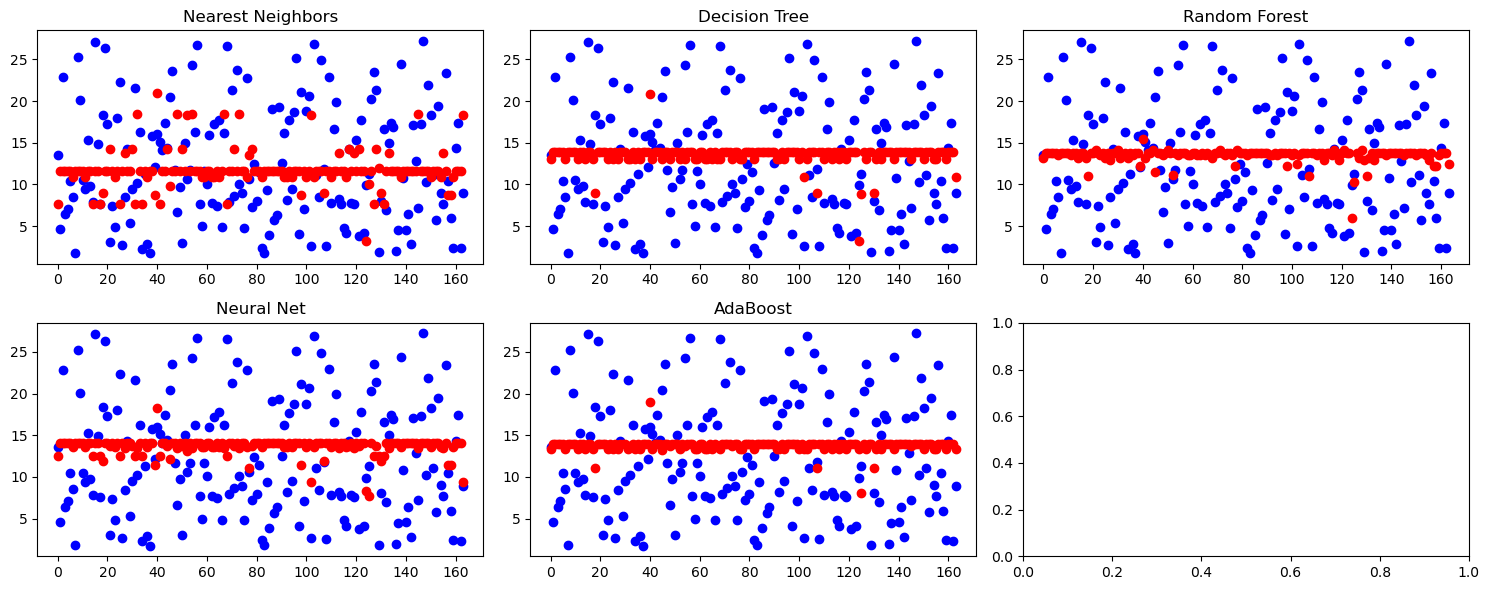

In [54]:
i=0
fig, axes = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')

axes = axes.ravel()
for name, rgr in zip(names, regressors):

    rgr.fit(Xrgr_train, yrgr_train)
    prediction = rgr.predict(Xrgr_test)
    print(name)
    print("MAE: "+str(metrics.mean_absolute_error(yrgr_test, prediction)))
    print("MSE: "+str(metrics.mean_squared_error(yrgr_test, prediction)))
    print("R-Squared: "+str(metrics.r2_score(yrgr_test, prediction)))
    # print("F1 Score:", metrics.f1_score(yrgr_test, prediction))
    # print("Average Precision:", metrics.average_precision_score(
    #     yrgr_test, prediction))
    #ConfusionMatrixDisplay.from_estimator(rgr, Xrgr_test, yrgr_test)
    #cm = metrics.confusion_matrix(yrgr_test, prediction)
    #print("Confusion Matrix: \n" + str(cm)+"\n")
    #RocCurveDisplay.from_estimator(rgr, Xrgr_test, yrgr_test)
    #ConfusionMatrixDisplay.from_estimator(rgr, Xrgr_test, yrgr_test,ax=axes[i])#.plot(ax=axes[i])
    #disp.plot(ax=axes[i])
    if max(yrgr_test) >= max(prediction):
        my_range = int(max(yrgr_test))
    else:
        my_range = int(max(prediction))
    axes[i].scatter(range(len(yrgr_test)), yrgr_test, color='blue')
    axes[i].scatter(range(len(prediction)), prediction, color='red')
    axes[i].set_title(name)
    

        
    i+=1
plt.tight_layout()